## BTS-notBTS classification for the Zwicky Transient Facility (ZTF) using deep learning

### Imports

In [1]:
from IPython.display import HTML, display
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import datetime
from astropy.time import Time
import tensorflow as tf

import os
import io
import gzip
from astropy.io import fits
from bson.json_util import loads, dumps
from astropy.stats import sigma_clipped_stats
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator


import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters, scatter_matrix
register_matplotlib_converters()
%matplotlib inline

In [2]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
})
plt.rcParams['axes.linewidth'] = 1.5

In [3]:
def only_pd_gr(trips, cand):
    cand['isdiffpos'] = [True if isdiffpos == 't' else False for isdiffpos in cand['isdiffpos']]
    
    # Diagnostics
    # iband = cand[cand['fid']==3]
    # neg_iband = iband[~iband['isdiffpos']]

    # iband_objids = iband['objectId'].value_counts().index.to_numpy()
    # iband_counts = iband['objectId'].value_counts().to_numpy()

    # cand_objids = cand['objectId'].value_counts().index.to_numpy()
    # cand_counts = cand['objectId'].value_counts().to_numpy()

    # print(f"Percent of alerts that are in the i-band {100*len(iband)/len(cand):.2f}%")
    # print(f"Percent of objects that have at least one i band alert {100*len(iband_objids)/len(cand_objids):.2f}%")

    # neg_iband_objids = neg_iband['objectId'].value_counts().index.to_numpy()
    # neg_iband_counts = neg_iband['objectId'].value_counts().to_numpy()

    # print(f"Percent of i-band alerts that have negative differences {100*len(neg_iband)/len(iband):.2f}%")

    cand_pd_gr = cand[(cand['isdiffpos']) & ((cand['fid'] == 1) | (cand['fid'] == 2))]
    triplets_pd_gr = trips[(cand['isdiffpos']) & ((cand['fid'] == 1) | (cand['fid'] == 2))]

    # print("Positive difference alerts in g- or r-band", len(cand_pd_gr))
    return triplets_pd_gr, cand_pd_gr



In [4]:
def create_train_data(set_names, cuts, name, N_max=None, seed=2):
    np.random.seed(seed)
    # concat
    # optionally save to disk? with provided name
    triplets = np.empty((0,63,63,3))
    cand = pd.DataFrame()

    for set_name in set_names:
        print(f"Working on {set_name} data")
        # load set
        set_trips = np.load(f"data/base_data/{set_name}_triplets.npy", mmap_mode='r')
        set_cand = pd.read_csv(f"data/base_data/{set_name}_candidates.csv", index_col=False)
        print("  Read")
        
        # run other optional cuts (ex: take only positive differences in g or r band)
        set_trips, set_cand = cuts(set_trips, set_cand)
        print("  Ran cuts")
        set_cand.reset_index(inplace=True, drop=True)

        # thin to N_max
        # plt.figure()
        # _ = plt.hist(set_cand['objectId'].value_counts(), histtype='step', bins=50)
        # plt.tight_layout()
        # plt.show()
        print(f"  Initial median of {np.median(set_cand['objectId'].value_counts())} detections per object")
        
        if N_max is not None:
            drops = np.empty((0,), dtype=int)
            for ID in set(set_cand['objectId']):
                reps = np.argwhere(np.asarray(set_cand['objectId']) == ID).flatten()
                if len(reps) >= N_max:
                    drops = np.concatenate((drops, np.random.choice(reps, len(reps)-N_max, replace=False)))
            
            set_trips = np.delete(set_trips, drops, axis=0)
            set_cand = set_cand.drop(index=drops)
            set_cand.reset_index(inplace=True)
            print(f"  Dropped {len(drops)} {set_name} alerts down to {N_max} max per obj")
        
        # concat
        triplets = np.concatenate((triplets, set_trips))
        cand = pd.concat((cand, set_cand))
        print(f"  Merged {set_name}")

    # or return?
    np.save(f"data/triplets_{name}{ f'_{N_max}max' if N_max is not None else '' }.npy", triplets)
    cand.to_csv(f"data/candidates_{name}{ f'_{N_max}max' if N_max is not None else '' }.csv", index=False)
    print("Wrote merged triplets and candidate data")
    del triplets, cand


#### What is causing nan loss
+ Not pd_gr cuts
+ suspected to be with values of triplets
    + normalization again?
    + /=max didnt fix
    + abs and /=max does fix
    + just abs didnt fix
+ some weird big negative thing in current data
+ MS alone breaks
+ BTS T&F works fine

Conclusion: weird big negative thing is in MS data, causing loss to give nan and model to fail

In [5]:
N_max = 30

In [6]:
create_train_data(['bts_true', 'bts_false', 'MS'], only_pd_gr, name="pd_gr", N_max=N_max)

Working on bts_true data
  Read
  Ran cuts
  Initial median of 49.0 detections per object
  Dropped 129867 bts_true alerts down to 30 max per obj
  Merged bts_true
Working on bts_false data
  Read
  Ran cuts
  Initial median of 36.0 detections per object
  Dropped 161310 bts_false alerts down to 30 max per obj
  Merged bts_false
Working on MS data
  Read
  Ran cuts
  Initial median of 15.0 detections per object
  Dropped 13441 MS alerts down to 30 max per obj
  Merged MS
Wrote merged triplets and candidate data


In [7]:
df = pd.read_csv(f'data/candidates_pd_gr_{N_max}max.csv')
# display(df)
# df.info()
# df.describe()
print(f'num_notbts: {np.sum(df.label == 0)}')
print(f'num_bts: {np.sum(df.label == 1)}')

# We will use memory mapping as the file is relatively large (1 GB)
triplets = np.load(f'data/triplets_pd_gr_{N_max}max.npy', mmap_mode='r')

num_notbts: 71673
num_bts: 67103


In [8]:
# ind = np.random.randint(0, high=len(triplets), size=5)
# for ii in ind:
#     print(f'candid: {df.loc[ii, "candid"]}, label: {df.loc[ii, "label"]}')
#     plot_triplet(triplets[ii, :], True)

Let's explore the dataset a little bit:

In [9]:
# fig = plt.figure(figsize=(8, 8), dpi=100)
# ax = fig.add_subplot(111)

# color_wheel = {0: "#dc3545", 
#                1: "#28a745"}
# colors = df["label"].map(lambda x: color_wheel.get(x))

# columns = ['magpsf', 'fwhm', 'ndethist', 'scorr']

# axx = scatter_matrix(df.loc[df.label >= 0, columns], color=[color_wheel[label] for label in df.label],
#                      alpha=0.2,  diagonal='hist', ax=ax, grid=True,
#                      hist_kwds={'color': 'darkblue', 'alpha': 0, 'bins': 50})

# for rc in range(len(columns)):
#     rc_y_max = 0
#     for group in color_wheel.keys():
#         y = df[df.label == group][columns[rc]]
#         hh = axx[rc][rc].hist(y, bins=50, alpha=0.5, color=color_wheel[group], density=1)
# #         print(np.min(hh[0]), np.max(hh[0]))
#         rc_y_max = max(rc_y_max, np.max(hh[0]))
#         axx[rc][rc].set_ylim([0, 1.1*rc_y_max])

# # scatter_matrix(df.loc[df.label == 0, ['magpsf', 'fwhm', 'ndethist']], 
# #                alpha=0.2,  diagonal='hist', ax=ax,
# #                hist_kwds={'color': '#dc3545', 'alpha': 0.5, 'bins': 100}, color='#dc3545')
# # scatter_matrix(df.loc[df.label == 1, ['magpsf', 'fwhm', 'ndethist']], 
# #                alpha=0.2,  diagonal='hist', ax=ax,
# #                hist_kwds={'color': '#28a745', 'alpha': 0.5, 'bins': 100}, color='#28a745')

In [10]:
# df['date'] = df['jd'].map(lambda x: Time(x, format='jd').datetime)
# fig = plt.figure(figsize=(7, 3), dpi=100)
# ax = fig.add_subplot(111)
# notbts = ax.hist(df.loc[df['label'] == 0, 'date'], bins=50, range=(17500,19100), #linestyle='dashed',
#         color=color_wheel[0], histtype='step', label='notBTS', linewidth=1.2)
# bts = ax.hist(df.loc[df['label'] == 1, 'date'], bins=50, range=(17500,19100),
#         color=color_wheel[1], histtype='step', label='BTS', linewidth=1.2)
# # ax.set_xlabel('Date')
# ax.set_ylabel('Count')
# ax.legend(loc='best')
# ax.grid(True, linewidth=.3)
# plt.tight_layout()

We will use 81\% / 9\% / 10\% training/validation/test data split:

In [11]:
test_split = 0.1  # fraction of all data
random_state = 2

ztfids_seen, ztfids_test = train_test_split(pd.unique(df['objectId']), test_size=test_split, random_state=random_state)

# Want array of indices for training alerts and testing alerts
# Need to shuffle because validation is bottom 10% of train - shuffle test as well for consistency
is_seen = df['objectId'].isin(ztfids_seen)
is_test = ~is_seen
mask_seen = shuffle(df.index.values[is_seen], random_state=random_state)
mask_test  = shuffle(df.index.values[is_test], random_state=random_state)

x_seen, y_seen = triplets[mask_seen], df['label'][mask_seen]
x_test,  y_test  = triplets[mask_test] , df['label'][mask_test]

num_seen_obj = len(ztfids_seen)
num_test_obj = len(ztfids_test)
num_obj = len(pd.unique(df['objectId']))
print(f"{num_seen_obj} seen/train+val objects")
print(f"{num_test_obj} unseen/test objects")
print(f"{100*(num_seen_obj/num_obj):.2f}%/{100*(num_test_obj/num_obj):.2f}% seen/unseen split by object\n")

num_seen_alr = len(x_seen)
num_test_alr = len(x_test)
num_alr = len(df['objectId'])
print(f"{num_seen_alr} seen/train+val alerts")
print(f"{num_test_alr} unseen/test alerts")
print(f"{100*(num_seen_alr/num_alr):.2f}%/{100*(num_test_alr/num_alr):.2f}% seen/unseen split by alert\n")


5290 seen/train+val objects
588 unseen/test objects
90.00%/10.00% seen/unseen split by object

124684 seen/train+val alerts
14092 unseen/test alerts
89.85%/10.15% seen/unseen split by alert



In [12]:
validation_split = 0.1  # fraction of the seen data

ztfids_train, ztfids_val = train_test_split(ztfids_seen, test_size=validation_split, random_state=random_state)

is_train = df['objectId'].isin(ztfids_train)
is_val = df['objectId'].isin(ztfids_val)
mask_train = shuffle(df.index.values[is_train], random_state=random_state)
mask_val  = shuffle(df.index.values[is_val], random_state=random_state)

x_train, y_train = triplets[mask_train], df['label'][mask_train]
x_val, y_val = triplets[mask_val], df['label'][mask_val]

num_train_obj = len(ztfids_train)
num_val_obj = len(ztfids_val)
num_obj = len(pd.unique(df['objectId']))
print(f"{num_train_obj} train objects")
print(f"{num_val_obj} val objects")
print(f"{100*(num_train_obj/num_obj):.2f}%/{100*(num_val_obj/num_obj):.2f}% train/val split by object\n")

num_train_alr = len(x_train)
num_val_alr = len(x_val)
num_alr = len(df['objectId'])
print(f"{num_train_alr} train alerts")
print(f"{num_val_alr} val alerts")
print(f"{100*(num_train_alr/num_alr):.2f}%/{100*(num_val_alr/num_alr):.2f}% train/val split by alert\n")


4761 train objects
529 val objects
81.00%/9.00% train/val split by object

111822 train alerts
12862 val alerts
80.58%/9.27% train/val split by alert



In [13]:
# x_train, y_train = shuffle(triplets[mask_train], df['label'][mask_train], random_state=random_state)
# x_test, y_test   = shuffle(triplets[mask_test], df['label'][mask_test], random_state=random_state)

# x_train, y_train = triplets[mask_train], df['label'][mask_traintrain_mask]
# x_test, y_test = triplets[mask_test], df['label'][mask_test]

### `braai` architecture

We will use a simple custom VGG-like sequential model ($VGG6$; this architecture was first proposed by the Visual Geometry Group of the Department of Engineering Science, University of Oxford, UK). The model has six layers with trainable parameters: four convolutional and two fully-connected. The first two convolutional layers use 16 3x3 pixel filters each while in the second pair, 32 3x3 pixel filters are used. To prevent over-fitting, a dropout rate of 0.25 is applied after each max-pooling layer and a dropout rate of 0.5 is applied after the second fully-connected layer. ReLU activation functions (Rectified Linear Unit --  a function defined as the positive part of its argument) are used for all five hidden trainable layers; a sigmoid activation function is used for the output layer.

![](img/fig-braai2.png)

In [14]:
def vgg6(input_shape=(63, 63, 3), n_classes: int = 1):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 63x63 images with 3 channel -> (63, 63, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25, name='drop_0.25'))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25, name='drop2_0.25'))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.4, name='drop3_0.4'))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### Model training

`braai` is implemented using `TensorFlow` software and its high-level `Keras` API. We will use the binary cross-entropy loss function, the Adam optimizer, a batch size of 64, and a 81\%/9\%/10\% training/validation/test data split. The training image data are weighted per class to mitigate the real vs. bogus imbalance in the data sets. To augment the data, the images may be flipped horizontally and/or vertically at random. No random rotations and translations will be added.

In [15]:
def save_report(path: str = './', stamp: str = None, report: dict = dict()):
    f_name = os.path.join(path, f'report.{stamp}.json')
    with open(f_name, 'w') as f:
        json.dump(report, f, indent=2)

# make train and test masks:
# _, _, mask_train, mask_test = train_test_split(df.label, list(range(len(df.label))),
#                                                    test_size=test_split, random_state=random_state)


masks = {'training': mask_train, 'val': mask_val, 'test': mask_test}

# print(mask_train)

In [16]:
tf.keras.backend.clear_session()

loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 100
patience = 50
class_weight = True
batch_size = 64

# halt training if no gain in validation accuracy over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

data_augmentation = {'horizontal_flip': True,
                     'vertical_flip': True,
                     'rotation_range': 0,  # should rotate !!!
                     'fill_mode': 'constant',
                     'cval': 1e-9}
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=data_augmentation['horizontal_flip'],
                                                          vertical_flip  =data_augmentation['vertical_flip'],
                                                          rotation_range =data_augmentation['rotation_range'],
                                                          fill_mode      =data_augmentation['fill_mode'],
                                                          cval           =data_augmentation['cval'])

training_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(x_val, y_val, batch_size=batch_size)

In [17]:
binary_classification = True if loss == 'binary_crossentropy' else False
n_classes = 1 if binary_classification else 2

# training data weights
if class_weight:
    # weight data class depending on number of examples?
    if not binary_classification:
        num_training_examples_per_class = np.sum(y_train, axis=0)
    else:
        num_training_examples_per_class = np.array([len(y_train) - np.sum(y_train), np.sum(y_train)])

    assert 0 not in num_training_examples_per_class, 'found class without any examples!'

    # fewer examples -- larger weight
    weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
    normalized_weight = weights / np.max(weights)

    class_weight = {i: w for i, w in enumerate(normalized_weight)}

else:
    class_weight = {i: 1 for i in range(2)}
    
# image shape:
image_shape = x_train.shape[1:]
print('Input image shape:', image_shape)

Input image shape: (63, 63, 3)


Build and compile the model:

In [18]:
model = vgg6(input_shape=image_shape, n_classes=n_classes)

# set up optimizer:
if optimizer == 'adam':
    optimzr = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)
elif optimizer == 'sgd':
    optimzr = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=True)
else:
    print('Could not recognize optimizer, using Adam')
    optimzr = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimzr, loss=loss, metrics=['accuracy'])

# print(model.summary())

In [19]:
assert not np.any(np.isnan(triplets))

Train!

In [20]:
run_t_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'{model.name}_{run_t_stamp}'

h = model.fit(training_generator,
              steps_per_epoch=0.8*len(x_train) // batch_size,
              validation_data=validation_generator,
              validation_steps=(0.8*len(x_test)) // batch_size,
              class_weight=class_weight,
              epochs=epochs,
              verbose=1, callbacks=[early_stopping])

Epoch 1/100


2022-07-23 15:13:05.131215: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1397/1397 [==============================] - 64s 45ms/step - loss: 0.6301 - accuracy: 0.6109 - val_loss: 0.6322 - val_accuracy: 0.6385
Epoch 2/100
1397/1397 [==============================] - 61s 44ms/step - loss: 0.5979 - accuracy: 0.6505 - val_loss: 0.6079 - val_accuracy: 0.6674
Epoch 3/100
1397/1397 [==============================] - 61s 43ms/step - loss: 0.5821 - accuracy: 0.6670 - val_loss: 0.6014 - val_accuracy: 0.6683
Epoch 4/100
1397/1397 [==============================] - 61s 44ms/step - loss: 0.5726 - accuracy: 0.6715 - val_loss: 0.5931 - val_accuracy: 0.6792
Epoch 5/100
1397/1397 [==============================] - 61s 43ms/step - loss: 0.5625 - accuracy: 0.6812 - val_loss: 0.5958 - val_accuracy: 0.6679
Epoch 6/100
1397/1397 [==============================] - 61s 44ms/step - loss: 0.5545 - accuracy: 0.6866 - val_loss: 0.5843 - val_accuracy: 0.6744
Epoch 7/100
1397/1397 [==============================] - 61s 44ms/step - loss: 0.5485 - accuracy: 0.6927 - val_loss: 0.5733 - val_

1397/1397 [==============================] - 65s 46ms/step - loss: 0.3308 - accuracy: 0.8369 - val_loss: 0.6542 - val_accuracy: 0.6851
Epoch 57/100
1397/1397 [==============================] - 65s 46ms/step - loss: 0.3301 - accuracy: 0.8367 - val_loss: 0.6858 - val_accuracy: 0.6804
Epoch 58/100
1397/1397 [==============================] - 63s 45ms/step - loss: 0.3239 - accuracy: 0.8407 - val_loss: 0.6465 - val_accuracy: 0.6950
Epoch 59/100
1397/1397 [==============================] - 63s 45ms/step - loss: 0.3234 - accuracy: 0.8400 - val_loss: 0.6895 - val_accuracy: 0.6813
Epoch 60/100
1397/1397 [==============================] - 64s 46ms/step - loss: 0.3217 - accuracy: 0.8413 - val_loss: 0.6821 - val_accuracy: 0.6802
Epoch 61/100
1397/1397 [==============================] - 63s 45ms/step - loss: 0.3204 - accuracy: 0.8437 - val_loss: 0.6957 - val_accuracy: 0.6835
Epoch 62/100
1397/1397 [==============================] - 62s 44ms/step - loss: 0.3173 - accuracy: 0.8437 - val_loss: 0.6883 

### Model evaluation

Let's now evaluate the resulting model:

In [21]:
print('Evaluating on training set to check misclassified samples:')
labels_training_pred = model.predict(x_train, batch_size=batch_size, verbose=1)
# XOR will show misclassified samples
misclassified_train_mask = np.array(list(map(int, df.label[masks['training']]))).flatten() ^ \
                           np.array(list(map(int, np.rint(labels_training_pred)))).flatten()

misclassified_train_mask = [ii for ii, mi in enumerate(misclassified_train_mask) if mi == 1]

misclassifications_train = {int(c): [int(l), float(p)]
                            for c, l, p in zip(df.candid.values[masks['training']][misclassified_train_mask],
                                               df.label.values[masks['training']][misclassified_train_mask],
                                               labels_training_pred[misclassified_train_mask])}
# print(misclassifications_train)

print('Evaluating on validation set for loss and accuracy:')
preds = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
val_loss = float(preds[0])
val_accuracy = float(preds[1])
print("Loss = " + str(val_loss))
print("Val Accuracy = " + str(val_accuracy))

print('Evaluating on validation set to check misclassified samples:')
preds = model.predict(x=x_val, batch_size=batch_size, verbose=1)

# XOR will show misclassified samples
misclassified_val_mask = np.array(list(map(int, df.label[masks['val']]))).flatten() ^ \
                          np.array(list(map(int, np.rint(preds)))).flatten()
misclassified_val_mask = [ii for ii, mi in enumerate(misclassified_val_mask) if mi == 1]

misclassifications_val = {int(c): [int(l), float(p)]
                           for c, l, p in zip(df.candid.values[masks['val']][misclassified_val_mask],
                                              df.label.values[masks['val']][misclassified_val_mask],
                                              preds[misclassified_val_mask])}

# round probs to nearest int (0 or 1)
labels_pred = np.rint(preds)

Evaluating on training set to check misclassified samples:
1748/1748 [==============================] - 22s 13ms/step
Evaluating on validation set for loss and accuracy:
201/201 [==============================] - 3s 14ms/step - loss: 0.7062 - accuracy: 0.6843
Loss = 0.7061727046966553
Val Accuracy = 0.6843414902687073
Evaluating on validation set to check misclassified samples:
201/201 [==============================] - 3s 14ms/step


In [22]:
report_dir = "models/"+model_name+"/"
model_dir = report_dir+"model/"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [23]:
fpr, tpr, thresholds = roc_curve(df['label'][masks['val']], preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
CFD = ConfusionMatrixDisplay.from_predictions(df.label.values[masks['val']], 
                                        labels_pred, normalize='true', ax=ax)
plt.close()

In [24]:
val_labels = np.array(list(map(int, df.label[masks['val']]))).flatten()
val_rpreds = np.array(list(map(int, np.rint(preds)))).flatten()

val_TP_mask = np.bitwise_and(val_labels, val_rpreds)
val_TN_mask = 1-(np.bitwise_or(val_labels, val_rpreds))
val_FP_mask = np.bitwise_and(1-val_labels, val_rpreds)
val_FN_mask = np.bitwise_and(val_labels, 1-val_rpreds)

val_TP_idxs = [ii for ii, mi in enumerate(val_TP_mask) if mi == 1]
val_TN_idxs = [ii for ii, mi in enumerate(val_TN_mask) if mi == 1]
val_FP_idxs = [ii for ii, mi in enumerate(val_FP_mask) if mi == 1]
val_FN_idxs = [ii for ii, mi in enumerate(val_FN_mask) if mi == 1]


In [25]:
# per object model accuracy for val objects in g, r bands
val_perobj_g_acc = np.zeros(len(ztfids_val))
val_perobj_r_acc = np.zeros(len(ztfids_val))

for i, ztfid in enumerate(ztfids_val): 
    cands = df[df['objectId']==ztfid]
    label = cands['label'].to_numpy()[0]

    g_cands = cands[cands['fid']==1]
    g_trips = triplets[df['objectId']==ztfid][cands['fid']==1]

    r_cands = cands[cands['fid']==2]
    r_trips = triplets[df['objectId']==ztfid][cands['fid']==2]

    if len(g_cands) > 0:
        g_preds = np.array(np.rint(model.predict(g_trips).flatten()), dtype=int)
        val_perobj_g_acc[i] = np.sum(g_preds==label)/len(g_trips)
    else:
        g_preds = []
        val_perobj_g_acc[i] = -1
     
    if len(r_cands) > 0:
        r_preds = np.array(np.rint(model.predict(r_trips).flatten()), dtype=int)
        val_perobj_r_acc[i] = np.sum(r_preds==label)/len(r_trips)
    else:
        r_preds = []
        val_perobj_r_acc[i] = -1
    
#     print(len(cands), label)
#     print(len(g_cands), len(r_cands))
#     print(g_preds, r_preds)
#     print(val_perobj_g_acc[i], val_perobj_r_acc[i])
#     print()


In [26]:
# generate training report in json format
print('Generating report...')
r = {'Run time stamp': run_t_stamp,
     'Model name': model_name,
     'Model trained': 'vgg6',
     'Batch size': batch_size,
     'Optimizer': optimizer,
     'Requested number of train epochs': epochs,
     'Early stopping after epochs': patience,
     'Training+validation/test split': test_split,
     'Training/validation split': validation_split,
     'Weight training data by class': class_weight,
     'Random state': random_state,
     'Number of training examples': x_train.shape[0],
     'Number of val examples': x_val.shape[0],
     'X_train shape': x_train.shape,
     'Y_train shape': y_train.shape,
     'X_val shape': x_val.shape,
     'Y_val shape': y_val.shape,
     'Data augmentation': data_augmentation,
     'val loss': val_loss,
     'val accuracy': val_accuracy,
     'Confusion matrix': CFD.confusion_matrix.tolist(),
     'Misclassified val candids': list(misclassifications_val.keys()),
     'Misclassified training candids': list(misclassifications_train.keys()),
     'Val misclassifications': misclassifications_val,
     'Training misclassifications': misclassifications_train,
     'Training history': h.history
     }
for k in r['Training history'].keys():
    r['Training history'][k] = np.array(r['Training history'][k]).tolist()

# print(r)

save_report(path=report_dir, stamp=run_t_stamp, report=r)
model.save(model_dir)

Generating report...


2022-07-23 16:20:11.591700: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/VGG6_20220723_151305/model/assets


In [27]:
with open(report_dir+'model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'), expand_nested=True, show_trainable=True)

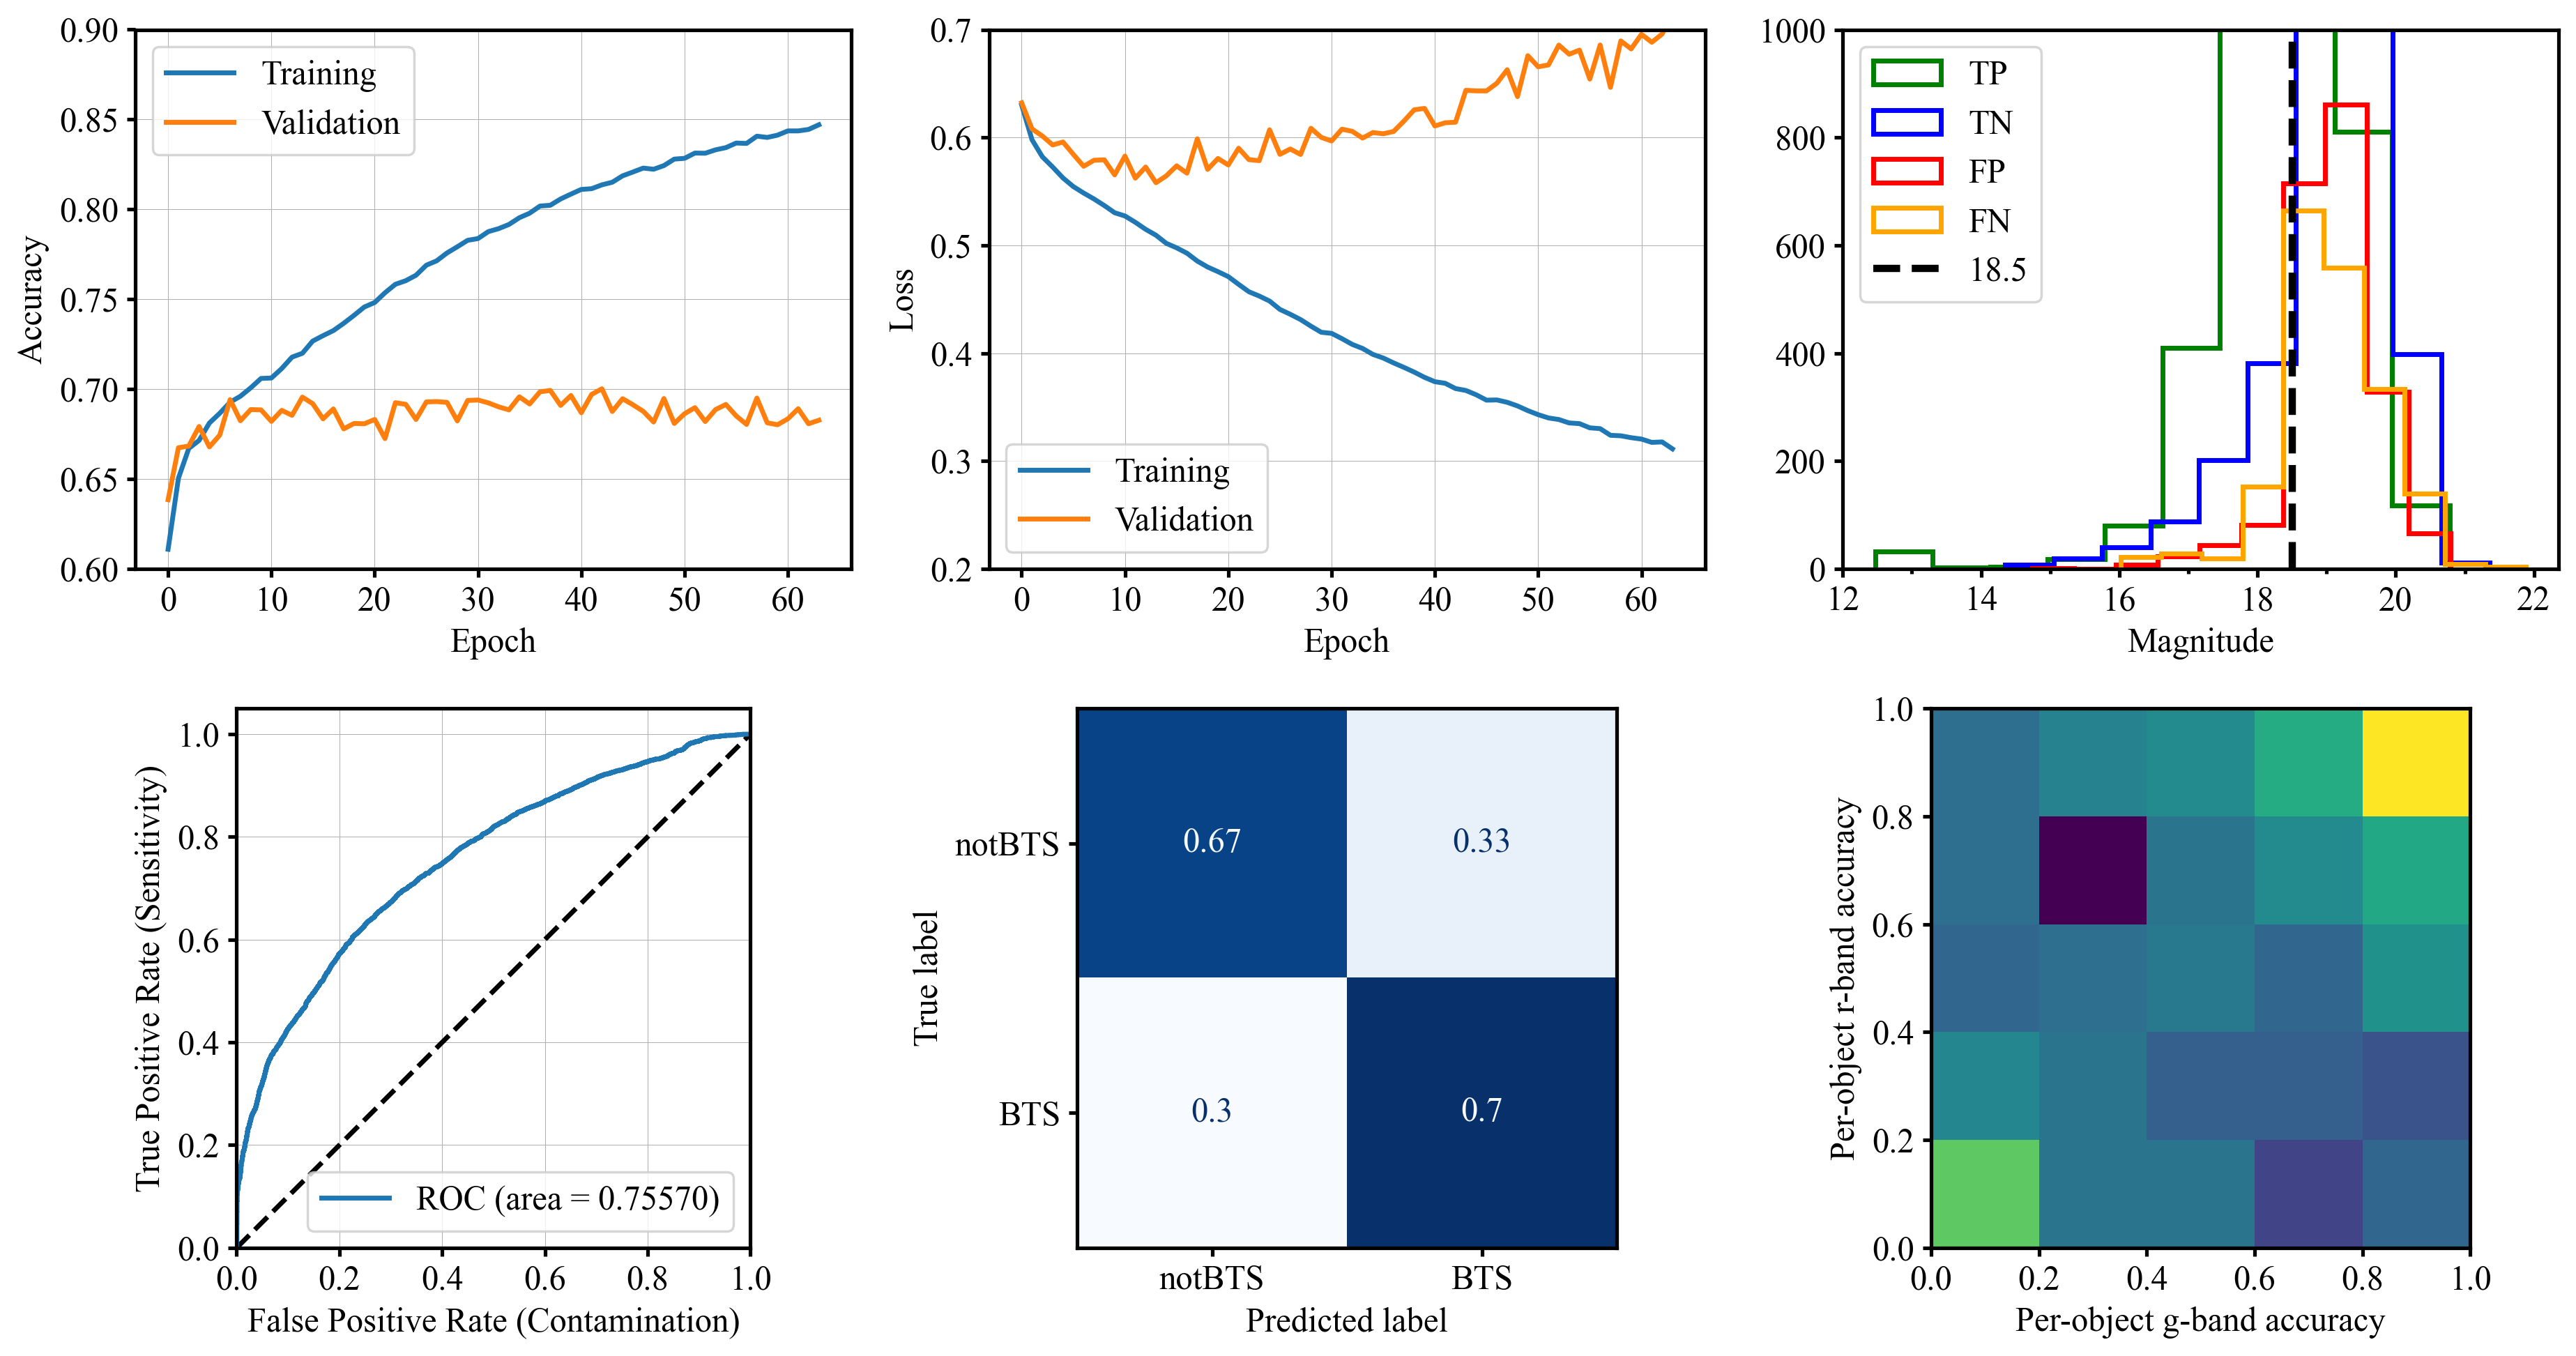

In [28]:
if 'accuracy' in h.history:
    train_acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
else:
    train_acc = h.history['acc']
    val_acc = h.history['val_acc']

train_loss = h.history['loss']
val_loss = h.history['val_loss']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), dpi=250)

ax1.plot(train_acc, label='Training', linewidth=2)
ax1.plot(val_acc, label='Validation', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')
ax1.set_ylim([0.6,0.9])
ax1.grid(True, linewidth=.3)

ax2.plot(train_loss, label='Training', linewidth=2)
ax2.plot(val_loss, label='Validation', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')
ax2.set_ylim([0.2,0.7])
ax2.grid(True, linewidth=.3)

ax3.hist(df['magpsf'][masks['val']].to_numpy()[val_TP_idxs], histtype='step', color='g', linewidth=2, label='TP')
ax3.hist(df['magpsf'][masks['val']].to_numpy()[val_TN_idxs], histtype='step', color='b', linewidth=2, label='TN')
ax3.hist(df['magpsf'][masks['val']].to_numpy()[val_FP_idxs], histtype='step', color='r', linewidth=2, label='FP')
ax3.hist(df['magpsf'][masks['val']].to_numpy()[val_FN_idxs], histtype='step', color='orange', linewidth=2, label='FN')
ax3.axvline(18.5, c='k', linewidth=3, linestyle='dashed', label='18.5')
ax3.legend(loc='upper left')
ax3.set_xlabel('Magnitude')
ax3.set_ylim([0,1000])
ax3.xaxis.set_minor_locator(MultipleLocator(1))

ax4.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.plot(fpr, tpr, lw=2, label=f'ROC (area = {roc_auc:.5f})')
ax4.set_xlabel('False Positive Rate (Contamination)')
ax4.set_ylabel('True Positive Rate (Sensitivity)')
ax4.legend(loc="lower right")
ax4.grid(True, linewidth=.3)
ax4.set(aspect='equal')

ConfusionMatrixDisplay.from_predictions(df.label.values[masks['val']], 
                                        labels_pred, normalize='true', 
                                        display_labels=["notBTS", "BTS"], 
                                        cmap=plt.cm.Blues, colorbar=False, ax=ax5)

ax6.hist2d(val_perobj_g_acc, val_perobj_r_acc, norm=LogNorm(), bins=5, range=[[0,1],[0,1]])
ax6.set_xlabel('Per-object g-band accuracy')
ax6.set_ylabel('Per-object r-band accuracy')
ax6.set(aspect='equal')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.tick_params(which='both', width=1.5)

plt.tight_layout()
plt.savefig(report_dir+"fig.pdf", bbox_inches='tight')
plt.show()

---

In [ ]:
def plot_lightcurve_class(ztfid):
    fid_to_color = {
        1: 'green',
        2: 'red',
        3: 'orange'
    }
    
    fid_to_band = {
        1: 'g',
        2: 'r',
        3: 'i'
    }
    
    cands = df[df['objectId']==ztfid]
    trips = triplets[df['objectId']==ztfid]
        
    first_detect = cands['jd'].min()
        
    fig, ax = plt.subplots(figsize=(8,5), dpi=200)
    
    for t_idx, c_idx in enumerate(cands.index):
        cand = cands.loc[c_idx]
        trip = trips[t_idx:t_idx+1]
        jd_since_fd = cand['jd'] - first_detect
        if int(np.rint(model.predict(trip)[0][0])):
            # predicted as BTS
            plt.errorbar(jd_since_fd, cand['magpsf'], fmt='*', ms=12, fillstyle='none', color=fid_to_color[cand['fid']], yerr=cand['sigmapsf'])
        else:
            # predicted as not BTS
            plt.errorbar(jd_since_fd, cand['magpsf'], fmt='s', fillstyle='none', color=fid_to_color[cand['fid']], yerr=cand['sigmapsf'])
    
    plt.plot([],[], marker='*', color='gray', fillstyle='none', label='BTS')
    plt.plot([],[], marker='s', color='gray', fillstyle='none', label='notBTS')
    
    ax.invert_yaxis()
    ax.set_xlabel("days since first detection", size=16, labelpad=10)
    ax.set_ylabel("PSF magnitude", size=16, labelpad=10)
    ax.legend()#, bbox_to_anchor=(1.2,1))
    ax.tick_params(which='both', width=1.5)
    ax.set_title()
    
    # change if statement
    # change plot labels
    # must run with N_max > 1 or read in all alerts for object
    
    return fig, ax

ztfid = ztfids_val[49]
print(ztfid)
fig, ax = plot_lightcurve_class(ztfid)
fig.tight_layout()
plt.show()

## Practical advice from one of DL godfathers Andrej Karpathy

Highly recommended: [Andrej Karpathy's blog post](http://karpathy.github.io/2019/04/25/recipe/)

- Neural net training is a leaky abstraction

```bash
>>> your_data = # plug your awesome dataset here
>>> model = SuperCrossValidator(SuperDuper.fit, your_data, ResNet50, SGDOptimizer)
# conquer world here
```

- Neural net training fails silently

Lots of ways to screw things up -> many paths to pain and suffering

#### The recipe

- Become one with the data
    - probably, the most important and time consuming step
    - visualize as much as you can
    - check normalizations
    
    
The neural net is effectively a compressed/compiled version of your dataset, you'll be able to look at your network (mis)predictions and understand where they might be coming from. And if your network is giving you some prediction that doesn't seem consistent with what you've seen in the data, something is off.


- Set up the end-to-end training/evaluation skeleton + get dumb baselines
    - fix random seed
    - simplify
    - add significant digits to your eval
    - init well
    - fancy loss func? verify at init
    - verify decreasing training loss
    - visualize just before the net
    - active learning: check model's misclassifications, both training and testing


- Overfit: first get a model large enough that it can overfit (i.e. focus on training loss) and then regularize it appropriately (give up some training loss to improve the validation loss).
    - picking the model: don't be a hero
    - adam is safe
    - complexify only one at a time


- Regularize
    - get more data
    - data augment
    - smaller model size
    - batchnorm
    - decrease the batch size
    - use dropout
    - early stopping


- Tune
    - first prefer random over grid search
    - hyper-parameter optimization. Check out [https://github.com/keras-team/keras-tuner](keras-tuner)


- Squeeze out the juice
    - ensembles
    - leave it training


In [ ]:
def remove_index_col(fname):
    df = pd.read_csv(fname)
    display(df)
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.drop("index", axis=1, inplace=True)
    display(df)
    df.to_csv(fname, index=False)

In [ ]:
# remove_index_col('data/MS_candidates.csv')